### TO FIND THE BESASELL SIZE OF BOTTLED WATER
Zeyuan Zhu: <br>
001519701

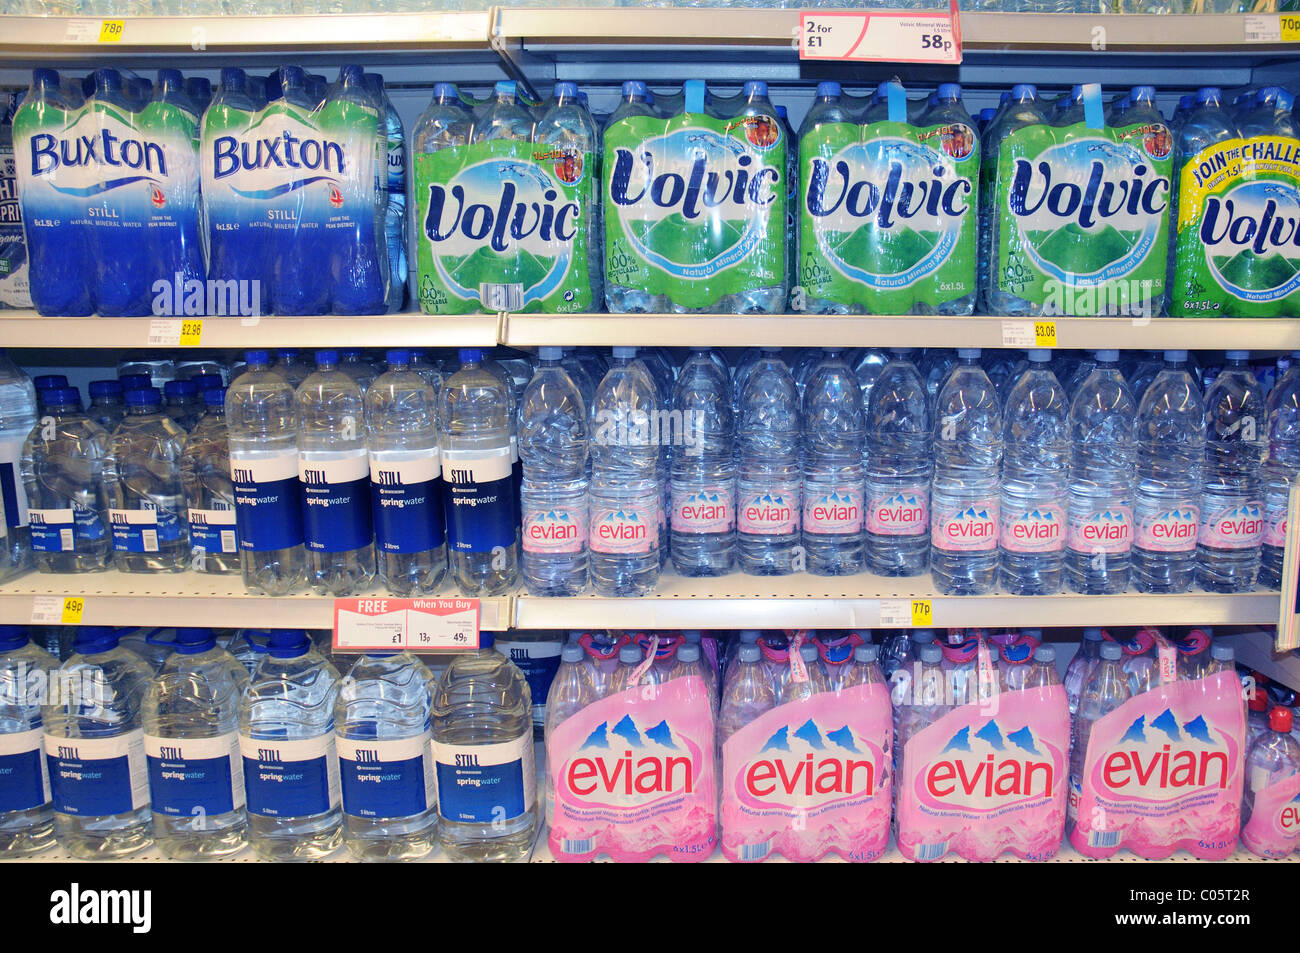

The Model is a analogy of bottled water in market. In the model, 4 algorthm will be test for finding the best sell size of bottled water. And deriving the best algorithm for different situations.

Small Size = 0.6 to buy

Medium Size = 0.9 to buy

Large Size = 0.7 to buy

#### Q1:Which hyperparameters are important for Thompson Sampling, e-greedy, UBC, and random sampling? Show that they are important

For Tompson Sampling, **NO** hyperparameter

For random Sampling, **NO** hyperparameter

For the epsilon greedy algorithm,the value of epsilon is an important hyperparameter which determins the Proportion of exploit and explore. It means the degree of greed of the algorithm 

For UCB, the important hyperparameter is the constant c in the below equation. It determins the aggressiveness of the algorithm. If c is a large number, it will fast convergence but unstable, vice versa。
$$
A_t = \text{argmax}_a \left[ Q_t(a) + c \sqrt{\frac{\ln t}{N_t (a)}} \right]
$$


In [1]:
import numpy as np
import matplotlib.pyplot as plt
from pdb import set_trace
import random

In [2]:
stationary = True
class Bandit():
    """
    Multi-armed bandit with rewards 1 or 0.[1]
    
    At initialization, multiple arms are created. The probability of each arm
    returning reward 1 if pulled is sampled from Bernouilli(p), where p randomly
    chosen from Uniform(0,1) at initialization
    """
    def __init__(self, arm_count):
        self.arm_count = arm_count
#         self.thetas = self.generate_thetas()
        self.generate_thetas()
        self.timestep = 0
        global stationary
        self.stationary = stationary
        
    def generate_thetas(self):
        if arm_count <= 3:
            self.thetas = np.asarray([0.6,0.9,0.7])
#             return np.asarray([0.6,0.9,0.7])
        else:
            self.thetas = np.random.uniform(0,1,self.arm_count)
#             return np.random.uniform(0,1,self.arm_count)
    
    
        
    def get_reward_regret(self, arm):

        self.timestep += 1
        if (self.stationary == False) and (self.timestep%100 == 0) :
            self.generate_thetas()
#             self.thetas = self.generate_thetas()
        # Simulate bernouilli sampling
        sim = np.random.uniform(0,1,self.arm_count)
        rewards = (sim < self.thetas).astype(int)
#         print(type(rewards))
#         print(rewards)
        reward = rewards[arm]
#         print(reward)
        regret = self.thetas.max() - self.thetas[arm]

        return reward, regret


  The algos try to learn which Bandit arm is the best to maximize reward.
  
  It does this by modelling the distribution of the Bandit arms with a Beta, 
  assuming the true probability of success of an arm is Bernouilli distributed.

  Args:
      bandit: the bandit class the algo is trying to model

In [3]:
class BetaAlgo():
  

    def __init__(self, bandit):

        self.bandit = bandit
        self.arm_count = bandit.arm_count
        self.alpha = np.ones(self.arm_count)
        self.beta = np.ones(self.arm_count)
  
    def get_reward_regret(self, arm):
        reward, regret = self.bandit.get_reward_regret(arm)
        self._update_params(arm, reward)
        return reward, regret

    def _update_params(self, arm, reward):
        self.alpha[arm] += reward
        self.beta[arm] += 1 - reward

class BernGreedy(BetaAlgo):
    def __init__(self, bandit):
        super().__init__(bandit)
  
    @staticmethod
    def name():
        return 'beta-greedy'

    def get_action(self):
        """ Bernouilli parameters are the expected values of the beta"""
        theta = self.alpha / (self.alpha + self.beta)
        return theta.argmax()
    
class BernThompson(BetaAlgo):
    def __init__(self, bandit):
        super().__init__(bandit)

    @staticmethod
    def name():
        return 'thompson'
  
    def get_action(self):
        """ Bernouilli parameters are sampled from the beta"""
        theta = np.random.beta(self.alpha, self.beta)
        return theta.argmax()


In [4]:
epsilon = 0.1 # para for epsilon
class EpsilonGreedy():
    """
  Epsilon Greedy with incremental update.
  Based on Sutton and Barto pseudo-code, page. 24
  """
    def __init__(self, bandit):
        global epsilon
        self.epsilon = epsilon
        self.bandit = bandit
        self.arm_count = bandit.arm_count
        self.Q = np.zeros(self.arm_count) # q-value of actions
        self.N = np.zeros(self.arm_count) # action count
  
    @staticmethod
    def name():
        return 'epsilon-greedy'
  
    def get_action(self):
        if np.random.uniform(0,1) > self.epsilon:
            action = self.Q.argmax()
        else:
            action = np.random.randint(0, self.arm_count)
        return action
  
    def get_reward_regret(self, arm):
        reward, regret = self.bandit.get_reward_regret(arm)
        self._update_params(arm, reward)
        return reward, regret

    def _update_params(self, arm, reward):
        self.N[arm] += 1 # increment action count
        self.Q[arm] += 1/self.N[arm] * (reward - self.Q[arm]) # inc. update rule

  

In [5]:
class RandomSampling():
    """Random Sampling is a special EpsilonGreedy which value epsolon = 1"""

    def __init__(self, bandit):
        global epsilon
        self.epsilon = 1
        self.bandit = bandit
        self.arm_count = bandit.arm_count
        self.Q = np.zeros(self.arm_count) # q-value of actions
        self.N = np.zeros(self.arm_count) # action count
  
    @staticmethod
    def name():
        return 'RandomSampling'
  
    def get_action(self):
        if np.random.uniform(0,1) > self.epsilon:
            action = self.Q.argmax()
        else:
            action = np.random.randint(0, self.arm_count)
        return action
  
    def get_reward_regret(self, arm):
        reward, regret = self.bandit.get_reward_regret(arm)
        self._update_params(arm, reward)
        return reward, regret

    def _update_params(self, arm, reward):
        self.N[arm] += 1 # increment action count
        self.Q[arm] += 1/self.N[arm] * (reward - self.Q[arm]) # inc. update rule



In [6]:
ucb_c = 2
class UCB():
    """
  Epsilon Greedy with incremental update.
  Based on Sutton and Barto pseudo-code, page. 24
  """
    def __init__(self, bandit):
        global ucb_c
        self.ucb_c = ucb_c
        self.bandit = bandit
        self.arm_count = bandit.arm_count
        self.Q = np.zeros(self.arm_count) # q-value of actions
        self.N = np.zeros(self.arm_count) + 0.0001 # action count
        self.timestep = 1
  
    @staticmethod
    def name():
        return 'ucb'
  
    def get_action(self):
        ln_timestep = np.log(np.full(self.arm_count, self.timestep))
        confidence = self.ucb_c * np.sqrt(ln_timestep/self.N)
        action = np.argmax(self.Q + confidence)
        self.timestep += 1
        return action
  
    def get_reward_regret(self, arm):
        reward, regret = self.bandit.get_reward_regret(arm)
        self._update_params(arm, reward)
        return reward, regret

    def _update_params(self, arm, reward):
        self.N[arm] += 1 # increment action count
        self.Q[arm] += 1/self.N[arm] * (reward - self.Q[arm]) # inc. update rule

In [7]:

def plot_data(y):
    """ y is a 1D vector """
    x = np.arange(y.size)
    _ = plt.plot(x, y, 'o')

    
def multi_plot_data(data, names):
    """ data, names are lists of vectors """
    x = np.arange(data[0].size)
    for i, y in enumerate(data):
        plt.plot(x, y, 'o', markersize=2, label=names[i])
    plt.legend(loc='upper right', prop={'size': 10}, numpoints=15)
    plt.show()
    
def simulate(simulations, timesteps, arm_count, Algorithm):
    """ Simulates the algorithm over 'simulations' epochs """
    sum_regrets = np.zeros(timesteps)
    for e in range(simulations):
        bandit = Bandit(arm_count)
        algo = Algorithm(bandit)
        regrets = np.zeros(timesteps)
        for i in range(timesteps):
            action = algo.get_action()
            reward, regret = algo.get_reward_regret(action)
            regrets[i] = regret
#             print(regrets)
        sum_regrets += regrets  
    mean_regrets = sum_regrets / simulations
    return mean_regrets

def experiment(arm_count, timesteps=500, simulations=500):
    """ 
  Standard setup across all experiments 
  Args:
    timesteps: (int) how many steps for the algo to learn the bandit
    simulations: (int) number of epochs
  """
    algos = [EpsilonGreedy, UCB, BernThompson, RandomSampling]
    regrets = []
    names = []
    for algo in algos:
        regrets.append(simulate(simulations, timesteps, arm_count, algo))
        names.append(algo.name())
    multi_plot_data(regrets, names)

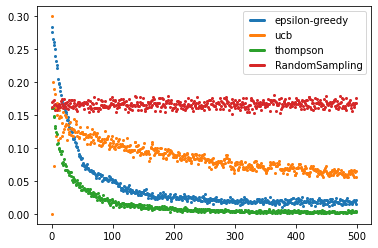

In [8]:

# Experiment 1
arm_count = 3 # number of arms in bandit
epsilon = 0.1
ucb_c = 2
stationary=True
experiment(arm_count)

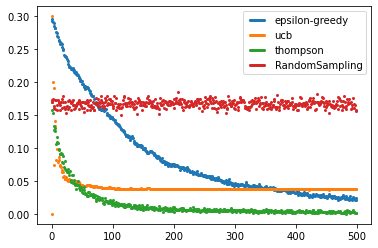

In [9]:
# Experiment 2
arm_count = 3 # number of arms in bandit
epsilon = 0.03
ucb_c = 0.1
stationary=True
experiment(arm_count)

#### Q2: How does the action space affect Thompson Sampling, e-greedy, UBC, and random sampling? Show why.

The Thompson agent very slowly, but surely, regret to eventually outperform 𝜖 -greedy around step 300, On the other hand, UCB is drastically unstable and decreases. The greedy algorithm need only sample a few values ​​and has a high probability of its most favourable action's estimated reward probability being close to the true optimal reward probability, ensuring it a low regret, even if it never chooses the optimal action. Thompson and UCB, on the other hand, with their emphasis on exploration, give a high premium to exploring actions not yet seen. Since there are so many actions, and since the mean rewards are evenly distributed between 0 and 1, there is a high cost of constantly exploring actions with rewards close to 0. Noticeably, the Thompson algorithm is incredibly stable across time, despite the large action space. Due to its sampling nature, it has a lower probability than UCB of constantly taking suboptimal actions. And for random sampling, it will not affected by action space

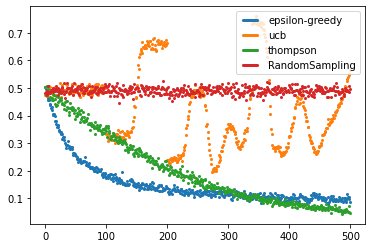

In [10]:
# Experiment 3
arm_count = 100 # number of arms in bandit
epsilon = 0.1
ucb_c = 2
stationary=True
experiment(arm_count)

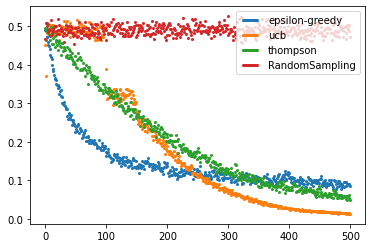

In [11]:
# Experiment 4
arm_count = 100 # number of arms in bandit
epsilon = 0.1
ucb_c = 0.01
stationary=True
experiment(arm_count)

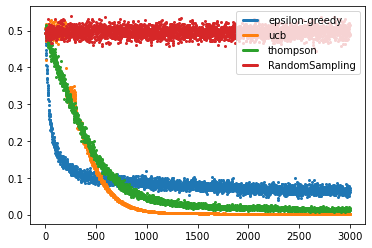

In [12]:
# Experiment 5
arm_count = 200 # number of arms in bandit
epsilon = 0.1
ucb_c = 0.01
stationary=True
experiment(arm_count, timesteps=3000, simulations=500)

#### Q3:How does stationary affect Thompson Sampling, e-greedy, UBC, and random sampling? Show why. 

after every 100 steps, the bandit resamples the action Bernouilli parameters. This places special emphasis on exploration. An algorithm that converges to an action and does not emphasize exploration will perform quite poorly as the true reward distribution changes over time . While the  𝜖 -greedy and Thompson's regret quickly decrease, on average they increase over time. On the other hand, UCB reacts much more quickly to the bandit non-stationarity, and actually continues to improve in regret over time, no doubt due to its higher emphasis on exploration. 

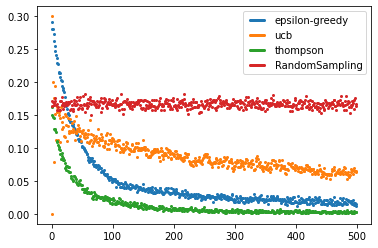

In [13]:
# Experiment 6
arm_count = 3 # number of arms in bandit
epsilon = 0.1
ucb_c = 2
stationary=False
experiment(arm_count)

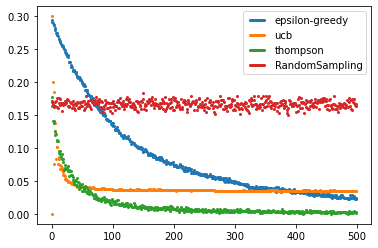

In [14]:
# Experiment 7
arm_count = 3 # number of arms in bandit
epsilon = 0.03
ucb_c = 0.1
stationary = False
experiment(arm_count)

#### Q4 : When do Thompson Sampling, e-greedy, UBC, and random sampling stop exploring? Explain why. Explain the exploration-exploitation tradeoff 

As picture below<br>
For random sampling, it will not stop exploring.

For epsilon-greedy, if the value of epsilon = 0, the algorithm will stop exploring.

For UBC, if the c = 0, the algorithm will always choose the arm have greater mean value, stop explring
$$
A_t = \text{argmax}_a \left[ Q_t(a) + c \sqrt{\frac{\ln t}{N_t (a)}} \right]
$$
For Tompson Sampling, it will not stop exploring, because every Beta distribution Continuous distribution on 0 to 1. There will always be an intersection, even if the area is very small.

Exploration-exploitation tradeoff is about problems how to balance exploration and exploitation. If explore to much, exploitation can not be maximized. If exploit too much, the regret value can not be  minimized[1]

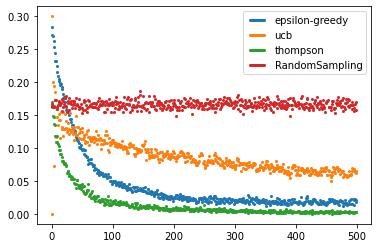

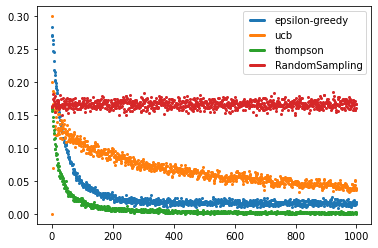

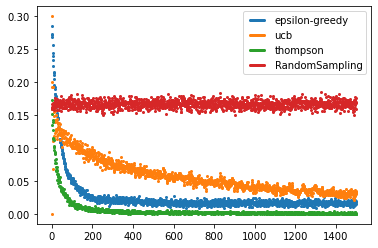

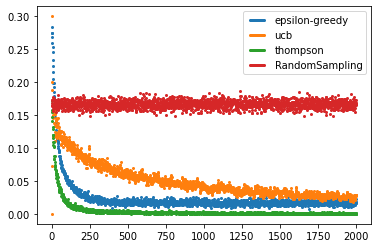

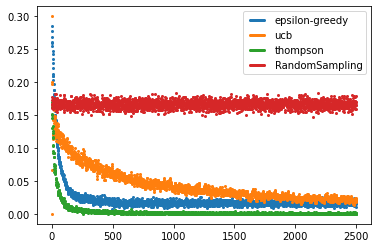

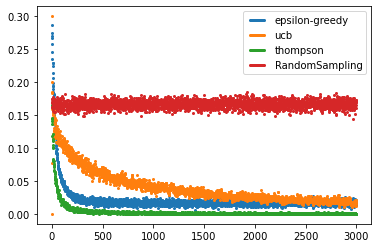

In [15]:
# Experiment 8
arm_count = 3 # number of arms in bandit
epsilon = 0.1
ucb_c = 2
stationary = True
experiment(arm_count, timesteps=500, simulations=500)
experiment(arm_count, timesteps=1000, simulations=500)
experiment(arm_count, timesteps=1500, simulations=500)
experiment(arm_count, timesteps=2000, simulations=500)
experiment(arm_count, timesteps=2500, simulations=500)
experiment(arm_count, timesteps=3000, simulations=500)

#### Q5: How long do Thompson Sampling, e-greedy, UBC, and random sampling remember the past actions? Explain your answer.  

Thompson Sampling remember all past actions

    def get_action(self):
        """ Bernouilli parameters are sampled from the beta"""
        theta = np.random.beta(self.alpha, self.beta)
        return theta.argmax()
    
    def _update_params(self, arm, reward):
        self.alpha[arm] += reward
        self.beta[arm] += 1 - reward

ϵ-greedy remember past action which update the Q value

    def get_action(self):
        if np.random.uniform(0,1) > self.epsilon:
            action = self.Q.argmax()
        else:
            action = np.random.randint(0, self.arm_count)
        return action
    
UCB remember past action which update the Q value or confidence

    def get_action(self):
        ln_timestep = np.log(np.full(self.arm_count, self.timestep))
        confidence = self.ucb_c * np.sqrt(ln_timestep/self.N)
        action = np.argmax(self.Q + confidence)
        self.timestep += 1
        return action

Random Sampling do **not** remember any past actions.

#### Q6: Thompson Sampling with non-Beta distribution (5 Points) Modify the Thompson Sampling to run with a different distribution 

In [23]:
# Thompson Sampling for normal distribution
class BetaAlgo():
  """
  The algos try to learn which Bandit arm is the best to maximize reward.
  
  It does this by modelling the distribution of the Bandit arms with a Beta, 
  assuming the true probability of success of an arm is Bernouilli distributed.
  """
  def __init__(self, bandit):
    """
    Args:
      bandit: the bandit class the algo is trying to model
    """
    self.bandit = bandit
    self.arm_count = bandit.arm_count
    self.alpha = np.ones(self.arm_count)
    self.beta = np.ones(self.arm_count)
  
  def get_reward_regret(self, arm):
    reward, regret = self.bandit.get_reward_regret(arm)
    self._update_params(arm, reward)
    return reward, regret

  def _update_params(self, arm, reward):
    self.alpha[arm] += reward
    self.beta[arm] += 1 - reward

class NormalThompson(BetaAlgo):
    def __init__(self, bandit):
        super().__init__(bandit)

    @staticmethod
    def name():
        return 'Normal Thompson'
  
    def get_action(self):
        """ Bernouilli parameters are sampled from the beta"""
        theta = np.random.normal(self.alpha, self.beta)
        return theta.argmax()

In [27]:
def modify_experiment(arm_count, timesteps=1000, simulations=500):
    """ 
  Standard setup across all experiments 
  Args:
    timesteps: (int) how many steps for the algo to learn the bandit
    simulations: (int) number of epochs
  """
    algos = [EpsilonGreedy, UCB, BernThompson, RandomSampling, NormalThompson]
    regrets = []
    names = []
    for algo in algos:
        regrets.append(simulate(simulations, timesteps, arm_count, algo))
        names.append(algo.name())
    multi_plot_data(regrets, names)

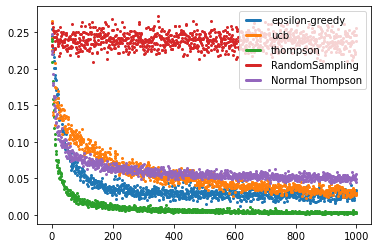

In [28]:
modify_experiment(3)

#### Q7: What code is yours and what have you adapted? 

Set the Bandit algorithm to simulate real-world problems

Desgin the random sampling 

Modify the multi_plot_data() to plot graph more clear

Modify experiment

Desgin the Normal Distribution Tompson Sampling


### Reference

https://en.wikipedia.org/wiki/Multi-armed_bandit<br>
https://facilethings.com/blog/en/the-exploration-exploitation-dilemma<br>
https://github.com/andrecianflone/thompson/blob/master/thompson.ipynb

### License

Copyright (c) 2022 Zeyuan Zhu.

Permission is hereby granted, free of charge, to any person obtaining a copy of this software and associated documentation files (the "Software"), to deal in the Software without restriction, including without limitation the rights to use, copy, modify, merge, publish, distribute, sublicense, and/or sell copies of the Software, and to permit persons to whom the Software is furnished to do so, subject to the following conditions:

The above copyright notice and this permission notice shall be included in all copies or substantial portions of the Software.

THE SOFTWARE IS PROVIDED "AS IS", WITHOUT WARRANTY OF ANY KIND, EXPRESS OR IMPLIED, INCLUDING BUT NOT LIMITED TO THE WARRANTIES OF MERCHANTABILITY, FITNESS FOR A PARTICULAR PURPOSE AND NONINFRINGEMENT. IN NO EVENT SHALL THE AUTHORS OR COPYRIGHT HOLDERS BE LIABLE FOR ANY CLAIM, DAMAGES OR OTHER LIABILITY, WHETHER IN AN ACTION OF CONTRACT, TORT OR OTHERWISE, ARISING FROM, OUT OF OR IN CONNECTION WITH THE SOFTWARE OR THE USE OR OTHER DEALINGS IN THE SOFTWARE.
